# Import libraries

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import log10
from math import pow
from math import sqrt
from random import randint

import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns

# Support functions

In [49]:

def clean_datasets(train, submission):
    object_columns = train.select_dtypes(include=['object'])
    for col in object_columns:
        dum = pd.get_dummies(train[col], prefix=col, dummy_na=True)
        train = train.merge(dum, left_index=True, right_index=True)
        submission = submission.merge(dum, left_index=True, right_index=True)
        train = train.drop(col, axis=1)
        submission = submission.drop(col, axis=1)

    num_cols = train.select_dtypes(include=['int32', 'float32', 'uint8'])
    for col in num_cols:
        train[col].fillna(0, inplace=True)
        if col != 'SalePrice':
            submission[col].fillna(0, inplace=True)
    return train, submission

def correlation_matrix(dataset, target_variable, top_variables=10):
    """
    Plot correlation matrix of a dataset with a column as the target_variable.
    Only shows X best top_variables.

    Code from:
    https://www.kaggle.com/junkal/selecting-the-best-regression-model/data
    """
    # Correlation built towards 'target_variable' column
    correlation = dataset.corr(method='pearson')
    columns = correlation.nlargest(top_variables, target_variable).index

    # Create correlation map
    correlation_map = np.corrcoef(dataset[columns].values.T)

    # Show correlation map
    sns.set(font_scale=1.0)
    heatmap = sns.heatmap(correlation_map, cbar=True, annot=True,
                          square=True, fmt='.2f',
                          yticklabels=columns.values,
                          xticklabels=columns.values)
    plt.show()


def show_info(dataset):
    """
    Copy of code to view preamble information of a dataset.

    Source:
    https://www.kaggle.com/kyakovlev/1st-place-solution-part-1-hands-on-data/
    """
    print("----------Top-5- Record----------")
    print(dataset.head(5))
    print("-----------Information-----------")
    print(dataset.info())
    print("-----------Data Types-----------")
    print(dataset.dtypes)
    print("----------Missing value-----------")
    print(dataset.isnull().sum())
    print("----------Null value-----------")
    print(dataset.isna().sum())
    print("----------Shape of Data----------")
    print(dataset.shape)
    print('Number of duplicates:', len(dataset[dataset.duplicated()]))


def downcast_dtypes(df):
    """Downcast floating and integer types of a dataframe
    Source:
    https://www.kaggle.com/anqitu/feature-engineer-and-model-ensemble-top-10
    """
    float_cols = [c for c in df if type(c) is not type(np.nan) and df[c].dtype == "float64"]
    int_cols = [c for c in df if type(c) is not type(np.nan) and df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int32)
    return df


In [50]:
# Load data
train = pd.read_csv('train.csv')
submission = pd.read_csv('test.csv')

### Some data insights

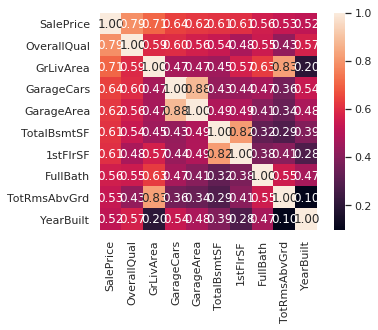

In [51]:
correlation_matrix(train, 'SalePrice')

In [52]:
train = downcast_dtypes(train)
submission = downcast_dtypes(submission)
train, submission = clean_datasets(train, submission)
show_info(train)

----------Top-5- Record----------
   Id  MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0   1          60         65.0     8450            7            5       2003   
1   2          20         80.0     9600            6            8       1976   
2   3          60         68.0    11250            7            5       2001   
3   4          70         60.0     9550            7            5       1915   
4   5          60         84.0    14260            8            5       2000   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  ...  SaleType_Oth  SaleType_WD  \
0          2003       196.0         706  ...             0            1   
1          1976         0.0         978  ...             0            1   
2          2002       162.0         486  ...             0            1   
3          1970         0.0         216  ...             0            1   
4          2000       350.0         655  ...             0            1   

   SaleType_nan  SaleCondition_Abn

# Model selection

In [53]:
model_seed = randint(0, 100)
XGBR = xgb.XGBRegressor(
    max_depth=5,
    min_child_weight=0.7,
    subsample=1,
    eta=0.15,
    num_round=100,
    seed=model_seed)
DTR = DecisionTreeRegressor(max_depth=5)
linear = LinearRegression()
models = [linear, XGBR, DTR]

# Training 

In [54]:
# Shuffle training data
train = train.sample(frac=1).reset_index(drop=True)

y = train['SalePrice'].values
X = train.drop('SalePrice', axis=1).values

# Normalize training data
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)

kfold = model_selection.KFold(n_splits=10, random_state=42, shuffle=False)

scores = np.zeros((10, len(models)))
for i, index in enumerate(kfold.split(X)):
    train_index, val_index = index
    X_train, X_val, y_train, y_val = X[train_index], X[val_index], y[train_index], y[val_index]
    
    [model.fit(X_train, y_train) for model in models]
    for j, model in enumerate(models):
        scores[i][j] = model.score(X_val, y_val)

print(scores)

[[-1.87722653e+19  8.69568368e-01  8.31153969e-01]
 [-2.92132952e+19  9.00809766e-01  7.73528666e-01]
 [-1.68084115e+18  9.05127832e-01  8.16806913e-01]
 [-3.26814853e+20  9.16366505e-01  7.51312863e-01]
 [-4.34001205e+18  9.10179792e-01  7.97698612e-01]
 [-2.33887310e+20  8.83961522e-01  7.33173944e-01]
 [ 8.46257759e-01  8.79493520e-01  7.35805380e-01]
 [-2.72116044e+17  8.63960741e-01  7.90788850e-01]
 [-6.65267514e+18  7.16500832e-01  5.73739382e-01]
 [-6.49645909e+19  9.33031387e-01  8.43360600e-01]]


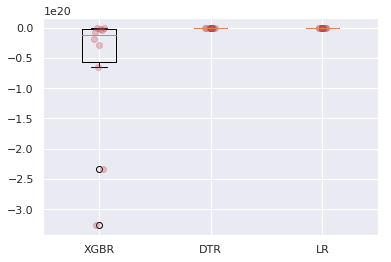

In [58]:
# Plot models performance
plt.boxplot(scores)
for i in range(len(models)):
    xderiv = (i+1)*np.ones(scores[:,i].shape)+(np.random.rand(10,)-0.5)*0.1
    plt.plot(xderiv,scores[:,i],'ro',alpha=0.3)

    
ax = plt.gca()
ax.set_xticklabels(['XGBR', 'DTR', 'LR'])
pass

In [121]:
pred = cross_val_predict(model, X, y, cv=10)

In [122]:
for i in range(len(y)):
    print(y[i], pred[i])

256000 189574.48
136000 136790.45
120000 124734.555
90000 115435.77
60000 70028.75
144000 141602.28
162000 169644.95
175000 196832.78
176500 178572.62
120500 112366.46
79900 81595.6
295493 283055.72
159000 150390.89
132000 131048.81
119000 109936.98
188000 195073.33
210000 220021.48
185000 180273.92
200624 211325.42
153000 157470.0
98600 129453.43
199900 206963.75
167900 162276.97
154000 188875.44
134000 127301.93
106000 110533.75
129900 140452.92
248000 215137.92
192000 196182.7
76000 86228.33
124900 122911.15
154000 157910.98
277000 249164.66
127500 130934.79
154000 154764.52
100000 77626.61
110000 110160.58
170000 180612.81
179665 204038.88
106250 97710.586
233170 221294.08
143000 201657.47
39300 49218.023
262000 283307.16
137000 138037.94
222500 233882.38
260000 296514.97
225000 245688.38
135000 141642.97
203000 216736.86
148000 143126.81
239000 205229.08
286000 249556.6
140000 140227.67
149900 153546.89
171750 183813.33
187000 203254.03
75500 84121.97
112000 113711.33
137500 11542

153500 170695.8
158900 154593.66
224900 212640.34
189000 148625.19
109500 109897.96
145000 154578.86
143000 171598.98
246578 219225.78
148000 147872.03
335000 265070.12
141000 99170.516
177000 184472.86
115000 156908.61
184000 195111.39
138000 138732.64
230000 228990.16
120000 120289.83
104000 129932.37
175000 149407.8
121600 110440.04
79500 110189.19
130500 132332.78
204000 200071.77
163500 186713.62
106500 95806.42
159895 176626.3
136900 152198.73
192140 173386.27
128000 107434.53
187500 212483.98
185000 190534.17
62383 127407.85
85400 95208.39
302000 305183.3
111250 121135.74
150000 167413.72
259000 235810.1
123500 130906.875
128000 123075.86
155000 161971.64
122000 117726.98
245000 248879.31
152000 128448.31
214000 212788.19
107500 110372.75
158000 157201.05
151400 160951.78
193500 203426.42
139000 123491.63
147000 308564.88
165000 159394.94
175500 165174.19
475000 372364.8
166000 172383.6
144000 139143.39
160000 146750.33
215000 207169.66
187500 202576.25
121500 179019.34
214500 1

In [170]:
y_predict = submission[train.drop('SalePrice', axis=1).columns].values
y_predict = scaler.fit_transform(y_predict)
predict = model.predict(y_predict)

submission['SalePrice'] = pd.Series(predict)
results = submission[['Id', 'SalePrice']]
results.SalePrice = results.SalePrice.apply(lambda price: pow(10, price))
results.to_csv('submission.csv', index=False)

/home/roc/.local/lib/python3.6/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [130]:
[print(col) for col in submission.columns]

Id
MSSubClass
LotFrontage
LotArea
OverallQual
OverallCond
YearBuilt
YearRemodAdd
MasVnrArea
BsmtFinSF1
BsmtFinSF2
BsmtUnfSF
TotalBsmtSF
1stFlrSF
2ndFlrSF
LowQualFinSF
GrLivArea
BsmtFullBath
BsmtHalfBath
FullBath
HalfBath
BedroomAbvGr
KitchenAbvGr
TotRmsAbvGrd
Fireplaces
GarageYrBlt
GarageCars
GarageArea
WoodDeckSF
OpenPorchSF
EnclosedPorch
3SsnPorch
ScreenPorch
PoolArea
MiscVal
MoSold
YrSold
SalePrice
MSZoning_C (all)
MSZoning_FV
MSZoning_RH
MSZoning_RL
MSZoning_RM
MSZoning_nan
Street_Grvl
Street_Pave
Street_nan
Alley_Grvl
Alley_Pave
Alley_nan
LotShape_IR1
LotShape_IR2
LotShape_IR3
LotShape_Reg
LotShape_nan
LandContour_Bnk
LandContour_HLS
LandContour_Low
LandContour_Lvl
LandContour_nan
Utilities_AllPub
Utilities_NoSeWa
Utilities_nan
LotConfig_Corner
LotConfig_CulDSac
LotConfig_FR2
LotConfig_FR3
LotConfig_Inside
LotConfig_nan
LandSlope_Gtl
LandSlope_Mod
LandSlope_Sev
LandSlope_nan
Neighborhood_Blmngtn
Neighborhood_Blueste
Neighborhood_BrDale
Neighborhood_BrkSide
Neighborhood_ClearCr
Nei

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,